## Importer les librairies

In [16]:
import numpy as np
import pandas as pd
import re
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import logging
import io
from contextlib import redirect_stdout, redirect_stderr
warnings.filterwarnings('ignore')
logging.getLogger('lightgbm').setLevel(logging.ERROR)
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay

## Charger le dataframe

In [17]:
df_final = pd.read_csv('../../Data/Cleaned_Dataframe.csv',sep=';')
colonnes_bool = ['ANTECEDENT_FAMILIAUX', 'DIABETE', 'EXPOSITION', 'ACOUPHENES']
for col in colonnes_bool:
    df_final[col] = df_final[col].replace({'True': True, 'False': False})
    df_final[col] = df_final[col].astype('boolean')  # gère aussi les <NA>
pd.set_option('display.max_columns', None)

On ajoute une variable qui catégorise le type de perte auditive, basé sur le test THR

In [18]:
thr_cols = [col for col in df_final.columns if col.startswith('FREQ_') and col.endswith('_THR')]
df_final['mean_thr'] = df_final[thr_cols].mean(axis=1)
def categoriser_perte(x):
    if x < 20:
        return 'Aucune'
    elif 20 <= x < 40:
        return 'Légère'
    elif 40 <= x < 60:
        return 'Moyenne'
    else:
        return 'Sévère'
df_final['PERTE'] = df_final['mean_thr'].apply(categoriser_perte)
df_final.drop(columns=['mean_thr'], inplace=True)
order_perte = ['Aucune', 'Légère', 'Moyenne', 'Sévère']
df_final['PERTE'] = pd.Categorical(
    df_final['PERTE'],
    categories=order_perte,
    ordered=True
)

---
## Création des variantes du dataset

On crée une liste de dataframes dans laquelle on va venir ajouter progressivement chaque dataframe que l'on crée

In [19]:
list_of_dfs = []
list_of_dfs.append(df_final)

On crée un dataframe avec uniquement les tests UCL et un avec uniquement les tests THR

In [20]:
df_UCL = df_final.drop(columns = df_final.columns[df_final.columns.str.endswith(('_THR'))])
df_THR = df_final.drop(columns = df_final.columns[df_final.columns.str.endswith(('_UCL'))])

list_of_dfs.append(df_UCL)
list_of_dfs.append(df_THR)
display(df_UCL.head())
display(df_THR.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_D_UCL,FREQ_250_G_UCL,FREQ_500_D_UCL,FREQ_500_G_UCL,FREQ_1000_D_UCL,FREQ_1000_G_UCL,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_UCL,FREQ_4000_G_UCL,FREQ_8000_D_UCL,FREQ_8000_G_UCL,PERTE
0,1,False,True,False,True,55.0,H,100.0,100.0,105.0,105.0,105.0,105.0,110.0,110.0,110.0,110.0,NaN,NaN,Légère
1,105,False,True,False,False,77.0,F,100.0,100.0,110.0,105.0,115.0,105.0,110.0,110.0,115.0,120.0,NaN,NaN,Moyenne
2,162,False,True,False,False,63.0,F,85.0,85.0,90.0,95.0,105.0,100.0,105.0,105.0,120.0,115.0,NaN,NaN,Sévère
3,345,False,True,False,True,65.0,F,95.0,90.0,100.0,90.0,100.0,95.0,100.0,95.0,90.0,100.0,90.0,85.0,Aucune
4,1120,False,True,False,True,0.0,F,83.0,88.0,95.0,0.0,87.0,94.0,89.0,87.0,90.0,94.0,NaN,NaN,Légère


,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_D_THR,FREQ_250_G_THR,FREQ_500_D_THR,FREQ_500_G_THR,FREQ_1000_D_THR,FREQ_1000_G_THR,FREQ_2000_D_THR,FREQ_2000_G_THR,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_8000_D_THR,FREQ_8000_G_THR,PERTE
0,1,False,True,False,True,55.0,H,20.0,30.0,25.0,40.0,25.0,40.0,35.0,55.0,60.0,65.0,NaN,NaN,Légère
1,105,False,True,False,False,77.0,F,20.0,35.0,35.0,30.0,30.0,30.0,35.0,35.0,60.0,65.0,60.0,60.0,Moyenne
2,162,False,True,False,False,63.0,F,25.0,30.0,50.0,45.0,80.0,80.0,80.0,85.0,105.0,100.0,105.0,105.0,Sévère
3,345,False,True,False,True,65.0,F,25.0,15.0,20.0,10.0,5.0,10.0,10.0,15.0,15.0,10.0,40.0,35.0,Aucune
4,1120,False,True,False,True,0.0,F,15.0,10.0,20.0,15.0,15.0,15.0,20.0,20.0,30.0,35.0,90.0,95.0,Légère


On crée un dataframe avec uniquement les colonnes de fréquence et acouphene

In [21]:
df_FREQ = df_final[['ACOUPHENES'] + [c for c in df_final if c.startswith('FREQ')]]

list_of_dfs.append(df_FREQ)
display(df_FREQ.head())

,ACOUPHENES,FREQ_250_D_THR,FREQ_250_G_THR,FREQ_250_D_UCL,FREQ_250_G_UCL,FREQ_500_D_THR,FREQ_500_G_THR,FREQ_500_D_UCL,FREQ_500_G_UCL,FREQ_1000_D_THR,FREQ_1000_G_THR,FREQ_1000_D_UCL,FREQ_1000_G_UCL,FREQ_2000_D_THR,FREQ_2000_G_THR,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_4000_D_UCL,FREQ_4000_G_UCL,FREQ_8000_D_THR,FREQ_8000_G_THR,FREQ_8000_D_UCL,FREQ_8000_G_UCL
0,True,20.0,30.0,100.0,100.0,25.0,40.0,105.0,105.0,25.0,40.0,105.0,105.0,35.0,55.0,110.0,110.0,60.0,65.0,110.0,110.0,NaN,NaN,NaN,NaN
1,True,20.0,35.0,100.0,100.0,35.0,30.0,110.0,105.0,30.0,30.0,115.0,105.0,35.0,35.0,110.0,110.0,60.0,65.0,115.0,120.0,60.0,60.0,NaN,NaN
2,True,25.0,30.0,85.0,85.0,50.0,45.0,90.0,95.0,80.0,80.0,105.0,100.0,80.0,85.0,105.0,105.0,105.0,100.0,120.0,115.0,105.0,105.0,NaN,NaN
3,True,25.0,15.0,95.0,90.0,20.0,10.0,100.0,90.0,5.0,10.0,100.0,95.0,10.0,15.0,100.0,95.0,15.0,10.0,90.0,100.0,40.0,35.0,90.0,85.0
4,True,15.0,10.0,83.0,88.0,20.0,15.0,95.0,0.0,15.0,15.0,87.0,94.0,20.0,20.0,89.0,87.0,30.0,35.0,90.0,94.0,90.0,95.0,NaN,NaN


On crée un dataframa avec la différence entre les colonnes UCL et THR

In [22]:
df_UCL_THR = df_final.copy()
pattern = r'^FREQ_(\d+)_([DG])_(UCL|THR)$'
freq_sides = {
    (m.group(1), m.group(2))
    for col in df_UCL_THR.columns
    if (m := re.match(pattern, col))
}
for hz, side in freq_sides:
    col_ucl = f'FREQ_{hz}_{side}_UCL'
    col_thr = f'FREQ_{hz}_{side}_THR'
    newcol  = f'FREQ_{hz}_{side}'
    df_UCL_THR[newcol] = df_UCL_THR[col_ucl] - df_UCL_THR[col_thr]

df_UCL_THR = df_UCL_THR.drop(columns=df_UCL_THR.columns[df_UCL_THR.columns.str.endswith(('_UCL', '_THR'))])

list_of_dfs.append(df_UCL_THR)
display(df_UCL_THR.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,PERTE,FREQ_500_D,FREQ_2000_G,FREQ_4000_D,FREQ_500_G,FREQ_4000_G,FREQ_250_D,FREQ_250_G,FREQ_1000_D,FREQ_8000_D,FREQ_1000_G,FREQ_8000_G,FREQ_2000_D
0,1,False,True,False,True,55.0,H,Légère,80.0,55.0,50.0,65.0,45.0,80.0,70.0,80.0,NaN,65.0,NaN,75.0
1,105,False,True,False,False,77.0,F,Moyenne,75.0,75.0,55.0,75.0,55.0,80.0,65.0,85.0,NaN,75.0,NaN,75.0
2,162,False,True,False,False,63.0,F,Sévère,40.0,20.0,15.0,50.0,15.0,60.0,55.0,25.0,NaN,20.0,NaN,25.0
3,345,False,True,False,True,65.0,F,Aucune,80.0,80.0,75.0,80.0,90.0,70.0,75.0,95.0,50.0,85.0,50.0,90.0
4,1120,False,True,False,True,0.0,F,Légère,75.0,67.0,60.0,-15.0,59.0,68.0,78.0,72.0,NaN,79.0,NaN,69.0


On crée un dataframe avec les fréquences uniquement entre 500 et 8000 hz

In [23]:
df_mid_FREQ = df_final.drop(columns = df_final.columns[df_final.columns.str.startswith(('FREQ_250', 'FREQ_8000'))])

list_of_dfs.append(df_mid_FREQ)
display(df_mid_FREQ.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_500_D_THR,FREQ_500_G_THR,FREQ_500_D_UCL,FREQ_500_G_UCL,FREQ_1000_D_THR,FREQ_1000_G_THR,FREQ_1000_D_UCL,FREQ_1000_G_UCL,FREQ_2000_D_THR,FREQ_2000_G_THR,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_4000_D_UCL,FREQ_4000_G_UCL,PERTE
0,1,False,True,False,True,55.0,H,25.0,40.0,105.0,105.0,25.0,40.0,105.0,105.0,35.0,55.0,110.0,110.0,60.0,65.0,110.0,110.0,Légère
1,105,False,True,False,False,77.0,F,35.0,30.0,110.0,105.0,30.0,30.0,115.0,105.0,35.0,35.0,110.0,110.0,60.0,65.0,115.0,120.0,Moyenne
2,162,False,True,False,False,63.0,F,50.0,45.0,90.0,95.0,80.0,80.0,105.0,100.0,80.0,85.0,105.0,105.0,105.0,100.0,120.0,115.0,Sévère
3,345,False,True,False,True,65.0,F,20.0,10.0,100.0,90.0,5.0,10.0,100.0,95.0,10.0,15.0,100.0,95.0,15.0,10.0,90.0,100.0,Aucune
4,1120,False,True,False,True,0.0,F,20.0,15.0,95.0,0.0,15.0,15.0,87.0,94.0,20.0,20.0,89.0,87.0,30.0,35.0,90.0,94.0,Légère


On crée un dataframpe avec les coefficients directeurs pour chaque freq et chaque test

In [24]:
# 1) copier le df de base
df_coeff = df_final.copy()

# 2) extraire toutes les fréquences existantes dans les colonnes FREQ_XXX_... 
pattern = r'^FREQ_(\d+)_([DG])_(UCL|THR)$'
# Set de fréquences (ex. {250, 500, 1000, …})
freqs = sorted({
    int(m.group(1))
    for col in df_coeff.columns
    if (m := re.match(pattern, col))
})
# transformer en chaines triées : ['250','500','1000',…]
freqs = list(map(str, freqs))

# 3) boucle pour créer les COEFF
coeffs = {}
for test in ['THR','UCL']:
    for side in ['D','G']:
        for i in range(len(freqs)-1):
            low, high = freqs[i], freqs[i+1]
            col_low  = f'FREQ_{low}_{side}_{test}'
            col_high = f'FREQ_{high}_{side}_{test}'
            newcol   = f'COEFF_{low}_{side}_{test}'
            coeffs[newcol] = df_coeff[col_high] - df_coeff[col_low]

# 4) nouveau DataFrame à partir du dict (index conservé)
df_coeff = pd.DataFrame(coeffs, index=df_coeff.index)
df_coeff = pd.concat([df_final[['ID_CLIENT', 'ANTECEDENT_FAMILIAUX', 'ACOUPHENES', 'DIABETE', 'EXPOSITION', 'AGE', 'SEXE']], df_coeff], axis=1)

list_of_dfs.append(df_coeff)
display(df_coeff.head())

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,COEFF_250_D_THR,COEFF_500_D_THR,COEFF_1000_D_THR,COEFF_2000_D_THR,COEFF_4000_D_THR,COEFF_250_G_THR,COEFF_500_G_THR,COEFF_1000_G_THR,COEFF_2000_G_THR,COEFF_4000_G_THR,COEFF_250_D_UCL,COEFF_500_D_UCL,COEFF_1000_D_UCL,COEFF_2000_D_UCL,COEFF_4000_D_UCL,COEFF_250_G_UCL,COEFF_500_G_UCL,COEFF_1000_G_UCL,COEFF_2000_G_UCL,COEFF_4000_G_UCL
0,1,False,True,False,True,55.0,H,5.0,0.0,10.0,25.0,NaN,10.0,0.0,15.0,10.0,NaN,5.0,0.0,5.0,0.0,NaN,5.0,0.0,5.0,0.0,NaN
1,105,False,True,False,False,77.0,F,15.0,-5.0,5.0,25.0,0.0,-5.0,0.0,5.0,30.0,-5.0,10.0,5.0,-5.0,5.0,NaN,5.0,0.0,5.0,10.0,NaN
2,162,False,True,False,False,63.0,F,25.0,30.0,0.0,25.0,0.0,15.0,35.0,5.0,15.0,5.0,5.0,15.0,0.0,15.0,NaN,10.0,5.0,5.0,10.0,NaN
3,345,False,True,False,True,65.0,F,-5.0,-15.0,5.0,5.0,25.0,-5.0,0.0,5.0,-5.0,25.0,5.0,0.0,0.0,-10.0,0.0,0.0,5.0,0.0,5.0,-15.0
4,1120,False,True,False,True,0.0,F,5.0,-5.0,5.0,10.0,60.0,5.0,0.0,5.0,15.0,60.0,12.0,-8.0,2.0,1.0,NaN,-88.0,94.0,-7.0,7.0,NaN


On crée un dataframe avec la différence entre l'oreille droite et l'oreille gauche

In [25]:
# 1) Liste des colonnes à conserver
base_cols = [
    'ANTECEDENT_FAMILIAUX',
    'ACOUPHENES',
    'DIABETE',
    'EXPOSITION',
    'AGE',
    'SEXE'
]

# 2) Les fréquences et tests à traiter
freqs = [250, 500, 1000, 2000, 4000, 8000]
tests = ['THR', 'UCL']

# 3) On part d'une copie du df d'origine pour ne pas le modifier “in-place”
df2 = df_final.copy()

# 4) Boucle de calcul des différences
for f in freqs:
    for t in tests:
        d_col   = f'FREQ_{f}_D_{t}'   # ex. 'FREQ_250_D_THR'
        g_col   = f'FREQ_{f}_G_{t}'   # ex. 'FREQ_250_G_THR'
        new_col = f'FREQ_{f}_{t}'     # ex. 'FREQ_250_THR'
        df2[new_col] = abs(df2[d_col] - df2[g_col])

# 5) On supprime toutes les colonnes D et G
to_drop = [f'FREQ_{f}_{side}_{t}'
           for f in freqs
           for t in tests
           for side in ('D','G')]
df2.drop(columns=to_drop, inplace=True)

# 6) On restreint l’ordre des colonnes : cliniques + différences
diff_cols = [f'FREQ_{f}_{t}' for f in freqs for t in tests]
df_diff_D_G = df2[ base_cols + diff_cols ]

list_of_dfs.append(df_diff_D_G)
display(df_diff_D_G.head())

,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_THR,FREQ_250_UCL,FREQ_500_THR,FREQ_500_UCL,FREQ_1000_THR,FREQ_1000_UCL,FREQ_2000_THR,FREQ_2000_UCL,FREQ_4000_THR,FREQ_4000_UCL,FREQ_8000_THR,FREQ_8000_UCL
0,False,True,False,True,55.0,H,10.0,0.0,15.0,0.0,15.0,0.0,20.0,0.0,5.0,0.0,NaN,NaN
1,False,True,False,False,77.0,F,15.0,0.0,5.0,5.0,0.0,10.0,0.0,0.0,5.0,5.0,0.0,NaN
2,False,True,False,False,63.0,F,5.0,0.0,5.0,5.0,0.0,5.0,5.0,0.0,5.0,5.0,0.0,NaN
3,False,True,False,True,65.0,F,10.0,5.0,10.0,10.0,5.0,5.0,5.0,5.0,5.0,10.0,5.0,5.0
4,False,True,False,True,0.0,F,5.0,5.0,5.0,95.0,0.0,7.0,0.0,2.0,5.0,4.0,5.0,NaN


---
## Prédictions de l'acouphène

LightGBM

In [26]:
def train_lightgbm(
    df: pd.DataFrame,
    n_splits: int = 5,
    top_k: int = 3
) -> None:
    """
    Entraîne un LightGBM avec validation croisée tunée, affiche :
     - performances CV (scores, matrice de confusion, ROC, importances)
     - PDP (numériques & catégorielles) des top_k variables importantes.
    
    Args :
        df       : DataFrame contenant la cible 'ACOUPHENES' ('Oui'/'Non')
        n_splits : nombre de plis pour la validation croisée (défaut=5)
        top_k    : nombre de variables clés pour lesquelles tracer le PDP (défaut=3)
    """
    # --- Préparation des données ---
    df = df.copy()
    df['target'] = df['ACOUPHENES'].astype('boolean') * 1
    X = df.drop(columns=['ID_CLIENT','ACOUPHENES','target'], errors='ignore')
    y = df['target']

    cat_cols = X.select_dtypes(include=['category','object']).columns.tolist()
    num_cols = X.select_dtypes(include=['number']).columns.tolist()

    # Imputation
    if num_cols:
        X[num_cols] = X[num_cols].fillna(X[num_cols].median())
    for c in cat_cols:
        if pd.api.types.is_categorical_dtype(X[c]):
            X[c] = X[c].cat.add_categories('missing').fillna('missing')
        else:
            X[c] = X[c].fillna('missing').astype('category')

    # --- Validation croisée tunée ---
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    y_true, y_pred, y_proba = [], [], []
    importances = np.zeros(X.shape[1])

    for tr_idx, vl_idx in skf.split(X, y):
        X_tr, X_val = X.iloc[tr_idx], X.iloc[vl_idx]
        y_tr, y_val = y.iloc[tr_idx], y.iloc[vl_idx]

        model = LGBMClassifier(
            n_estimators=1000,
            learning_rate=0.03,
            num_leaves=64,
            max_depth=10,
            min_child_samples=30,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,
            reg_lambda=0.5,
            random_state=42,
            verbosity=-1,
            silent=True,
            verbose=-1
        )

        # Entraînement silencieux
        with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
            model.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='auc',
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(period=0)],
                categorical_feature=cat_cols
            )

        p = model.predict_proba(X_val, num_iteration=model.best_iteration_)[:,1]
        pr = (p >= 0.5).astype(int)
        y_true.extend(y_val)
        y_pred.extend(pr)
        y_proba.extend(p)
        importances += model.booster_.feature_importance(importance_type='gain')

    # --- Affichage résultats CV ---
    importances /= n_splits
    fi = pd.DataFrame({'feature':X.columns,'importance':importances})
    fi.sort_values('importance', ascending=False, inplace=True)

    print(f"=== CV {n_splits} plis — hyperparams tunés ===")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("\nClassification Report:\n",
          classification_report(y_true, y_pred, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non','Oui'], yticklabels=['Non','Oui'])
    plt.title("Matrice de confusion (CV tuné)")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.4f}")
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.title("ROC Curve (CV tuné)")
    plt.legend(loc="lower right")
    plt.show()

    plt.figure(figsize=(8, max(4, 0.3 * len(fi))))
    sns.barplot(x='importance', y='feature', data=fi.head(20))
    plt.title("Top 20 variables (gain moyen CV)")
    plt.tight_layout()
    plt.show()

    # --- PDP pour les top_k variables ---
    top_vars = fi['feature'].head(top_k).tolist()
    num_top = [f for f in top_vars if f in num_cols]
    cat_top = [f for f in top_vars if f in cat_cols]

    # Entraînement final sur tout le jeu
    final = LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.03,
        num_leaves=64,
        max_depth=10,
        min_child_samples=30,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.5,
        reg_lambda=0.5,
        random_state=42,
        verbosity=-1
    )
    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        final.fit(X, y, categorical_feature=cat_cols)

    # PDP numériques
    if num_top:
        PartialDependenceDisplay.from_estimator(
            final, X, features=num_top,
            kind='average', grid_resolution=50
        )
        plt.suptitle(f"PDP (numériques) — top {top_k}", fontsize=14)
        plt.tight_layout()
        plt.show()

    # PDP catégorielles
    for c in cat_top:
        means = []
        cats = X[c].cat.categories
        for val in cats:
            mask = X[c] == val
            if not mask.any(): continue
            means.append(final.predict_proba(
                X.loc[mask], num_iteration=final.best_iteration_
            )[:,1].mean())
        df_cat = pd.DataFrame({c: cats[:len(means)], 'mean_proba': means})
        plt.figure(figsize=(6,4))
        sns.barplot(x=c, y='mean_proba', data=df_cat)
        plt.title(f"PDP catégorielle — {c}")
        plt.ylabel("Pr(ACOUPHENES=Oui)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.5918747490967483
Precision: 0.5781077641069156
Recall   : 0.4682796068458313
F1-score : 0.51742993848257

Classification Report:
               precision    recall  f1-score   support

           0     0.6003    0.7003    0.6464     33177
           1     0.5781    0.4683    0.5174     29098

    accuracy                         0.5919     62275
   macro avg     0.5892    0.5843    0.5819     62275
weighted avg     0.5899    0.5919    0.5861     62275



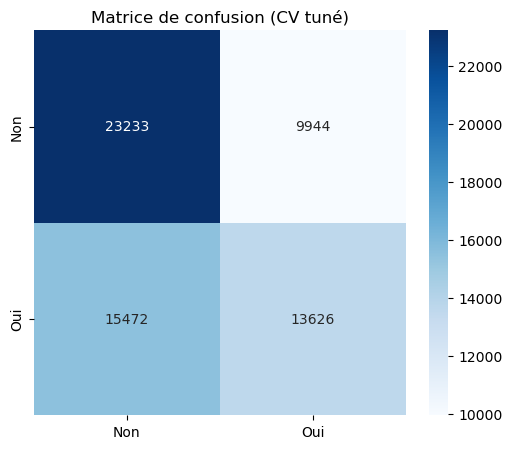

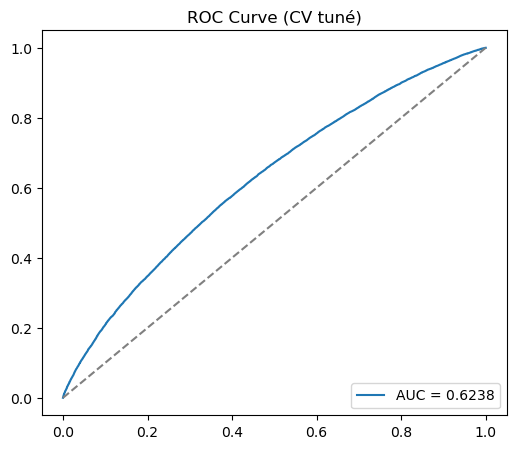

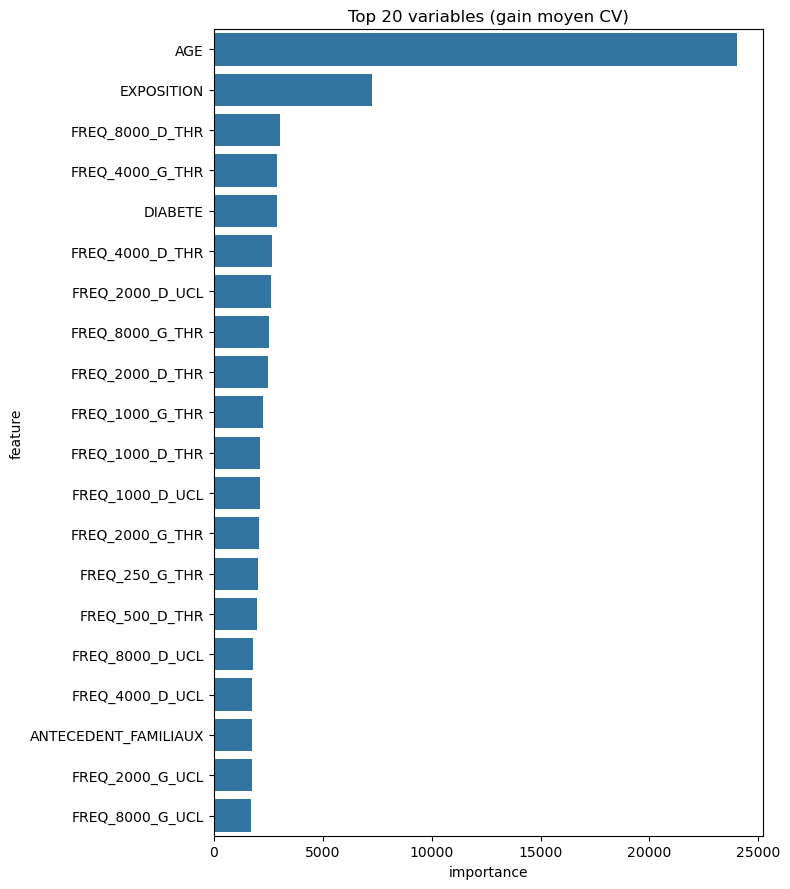

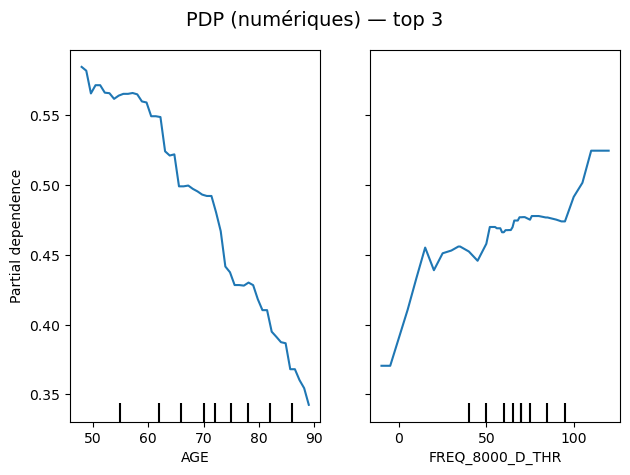

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.5879084704937776
Precision: 0.5743796284266597
Recall   : 0.4558045226476046
F1-score : 0.5082680258291977

Classification Report:
               precision    recall  f1-score   support

           0     0.5959    0.7038    0.6453     33177
           1     0.5744    0.4558    0.5083     29098

    accuracy                         0.5879     62275
   macro avg     0.5851    0.5798    0.5768     62275
weighted avg     0.5858    0.5879    0.5813     62275



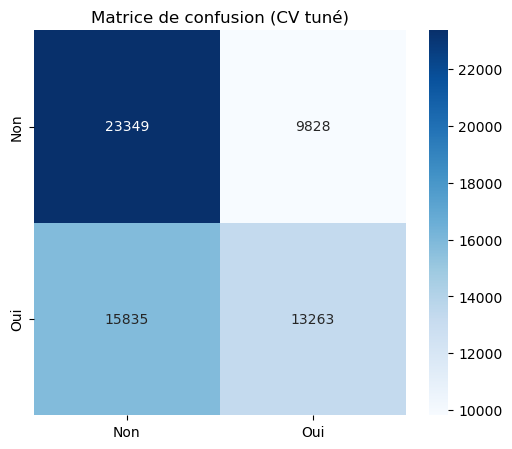

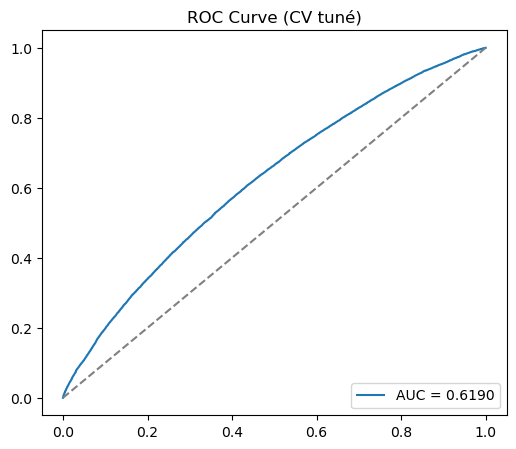

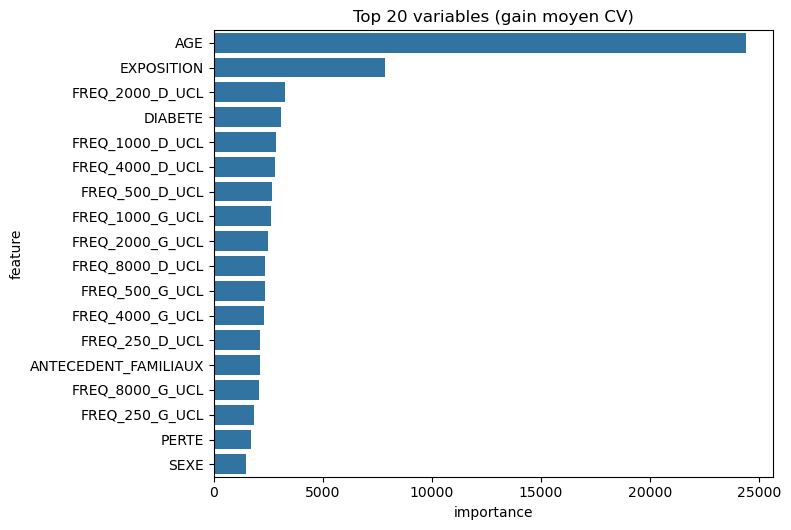

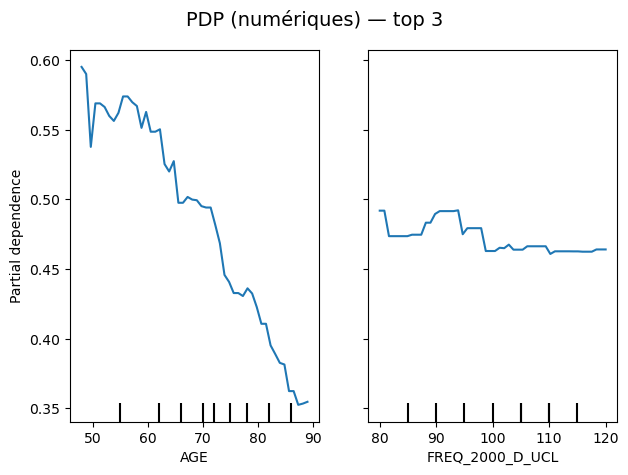

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.5875712565234845
Precision: 0.5735966198154695
Recall   : 0.45721355419616466
F1-score : 0.5088350034422091

Classification Report:
               precision    recall  f1-score   support

           0     0.5959    0.7019    0.6446     33177
           1     0.5736    0.4572    0.5088     29098

    accuracy                         0.5876     62275
   macro avg     0.5847    0.5796    0.5767     62275
weighted avg     0.5855    0.5876    0.5811     62275



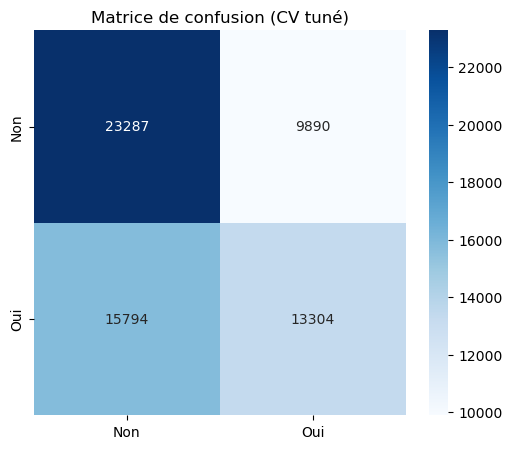

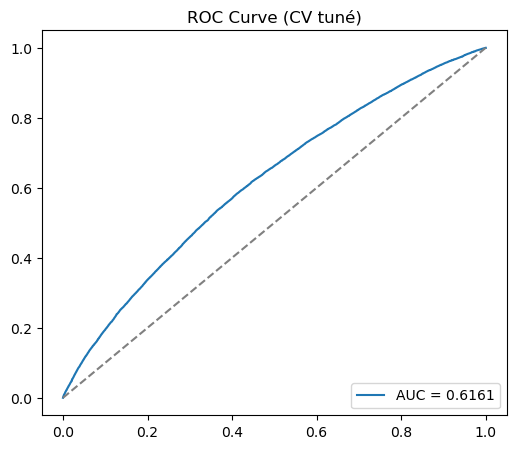

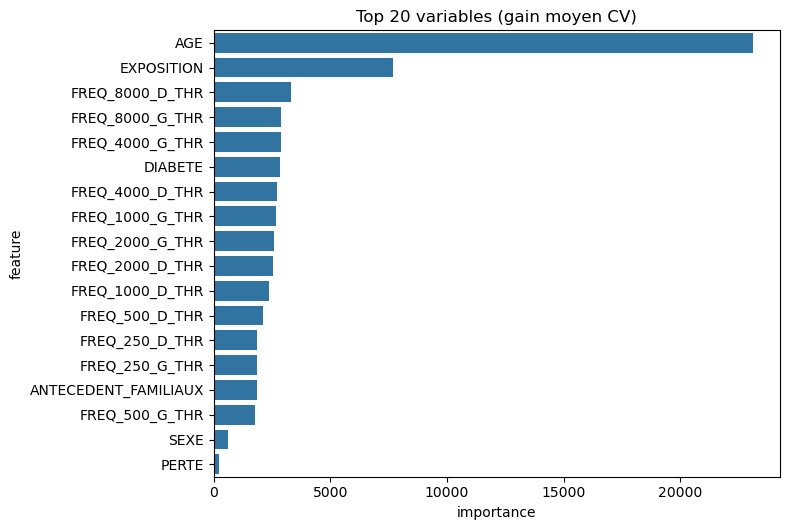

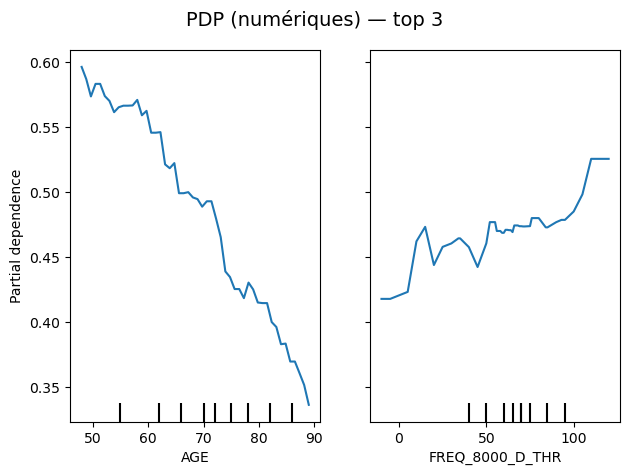

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.566985146527499
Precision: 0.5628834355828221
Recall   : 0.32792631795999727
F1-score : 0.41441910966340934

Classification Report:
               precision    recall  f1-score   support

           0     0.5685    0.7767    0.6565     33177
           1     0.5629    0.3279    0.4144     29098

    accuracy                         0.5670     62275
   macro avg     0.5657    0.5523    0.5355     62275
weighted avg     0.5659    0.5670    0.5434     62275



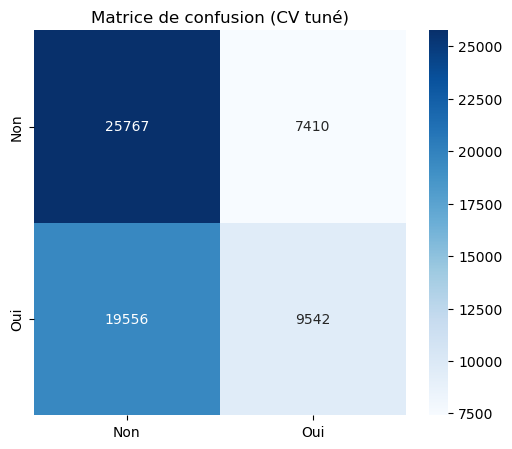

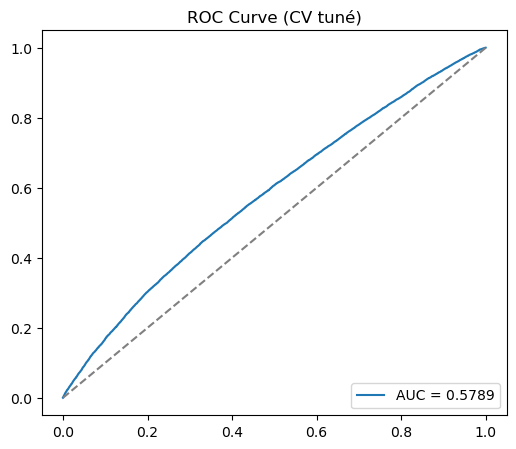

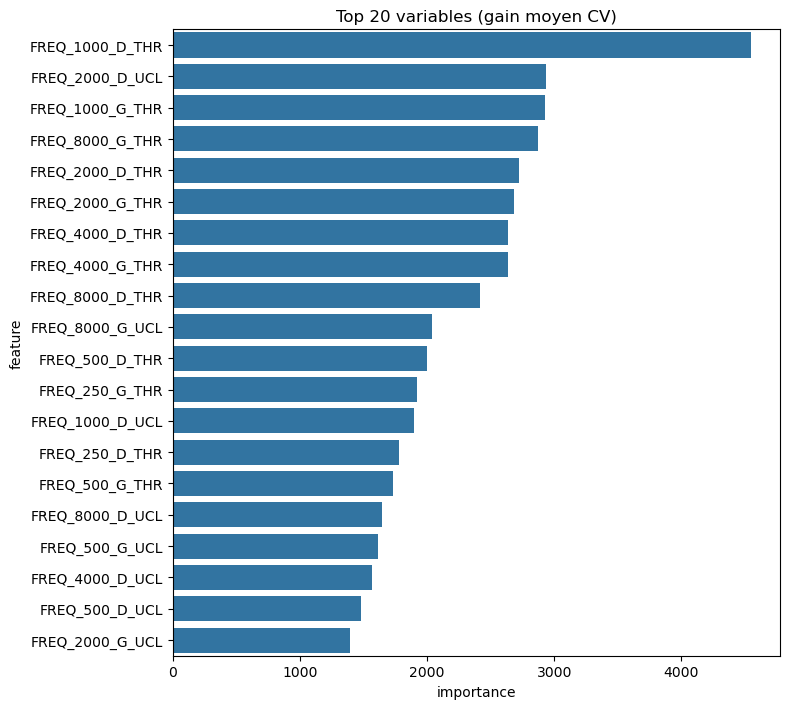

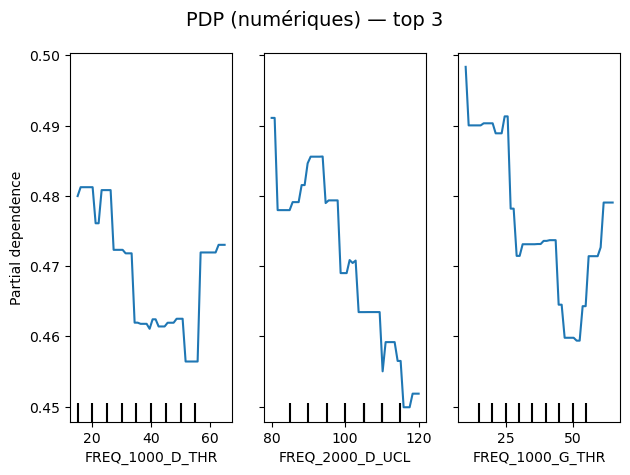

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.5840385387394621
Precision: 0.5793185656104103
Recall   : 0.4008522922537631
F1-score : 0.4738381540461489

Classification Report:
               precision    recall  f1-score   support

           0     0.5863    0.7447    0.6561     33177
           1     0.5793    0.4009    0.4738     29098

    accuracy                         0.5840     62275
   macro avg     0.5828    0.5728    0.5650     62275
weighted avg     0.5830    0.5840    0.5709     62275



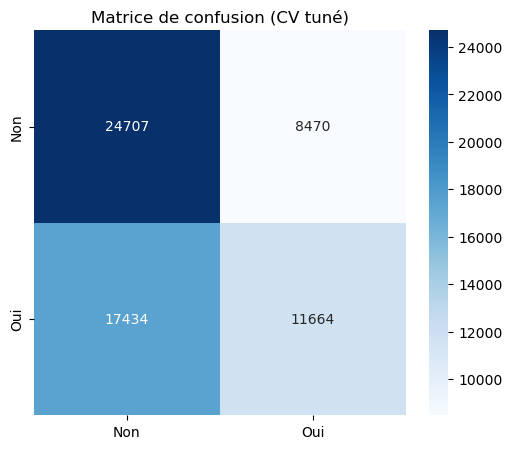

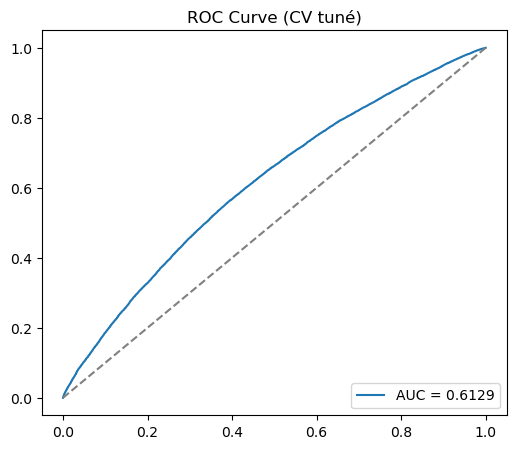

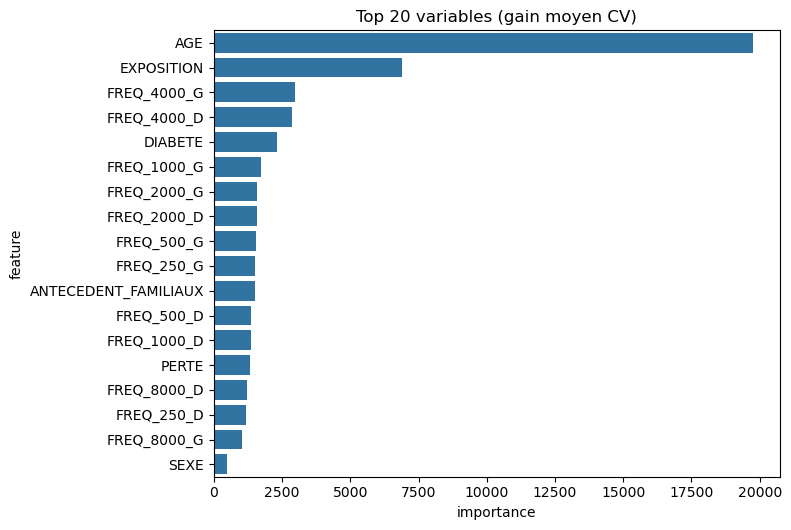

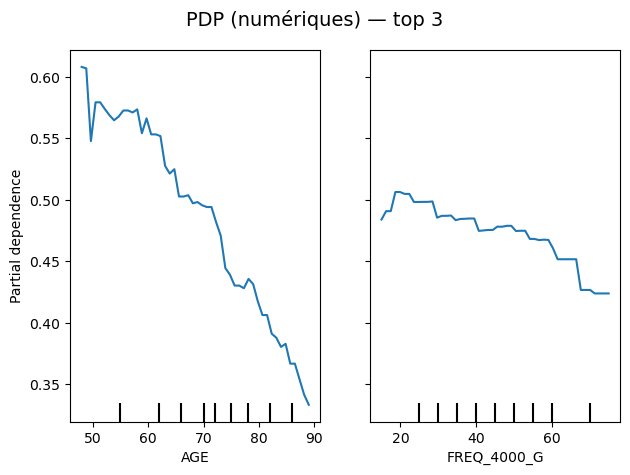

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.5890806904857487
Precision: 0.5746827897470834
Recall   : 0.46384631246133756
F1-score : 0.5133500684618896

Classification Report:
               precision    recall  f1-score   support

           0     0.5978    0.6989    0.6444     33177
           1     0.5747    0.4638    0.5134     29098

    accuracy                         0.5891     62275
   macro avg     0.5862    0.5814    0.5789     62275
weighted avg     0.5870    0.5891    0.5832     62275



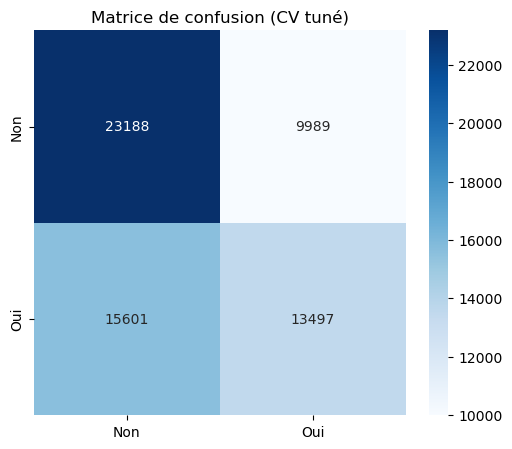

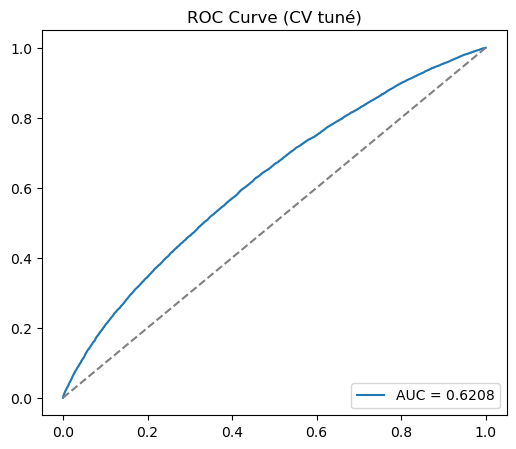

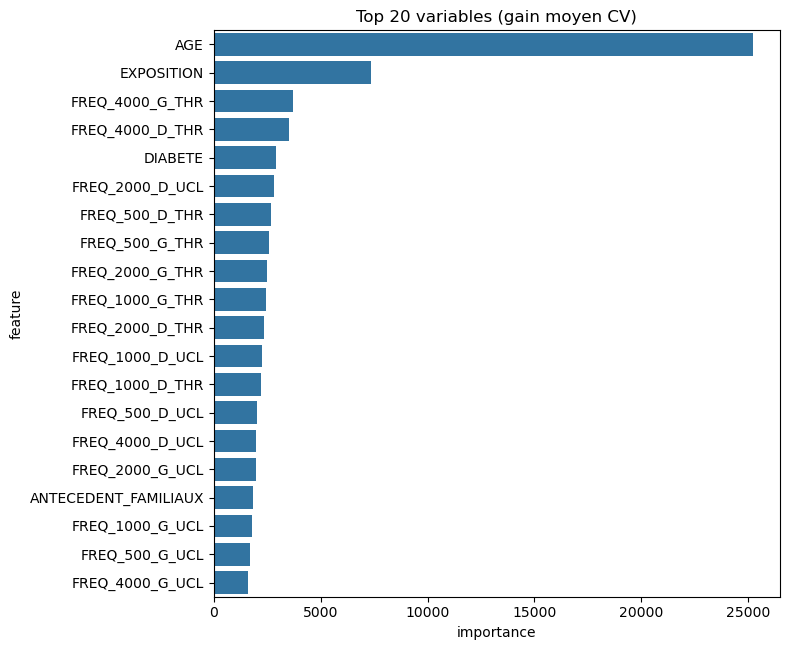

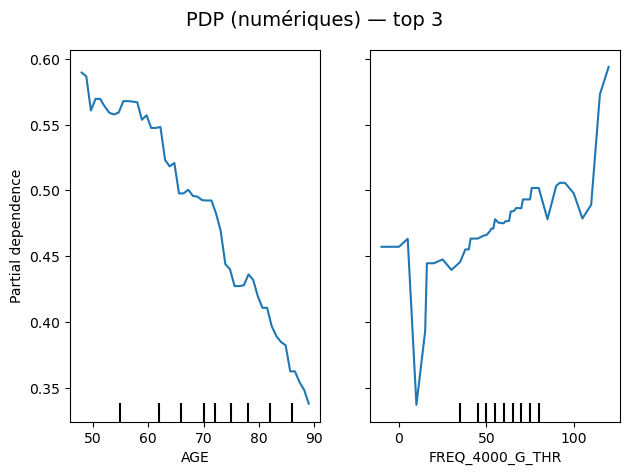

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.5853552790044159
Precision: 0.5801134696273109
Recall   : 0.40762251701147845
F1-score : 0.4788067172614242

Classification Report:
               precision    recall  f1-score   support

           0     0.5879    0.7412    0.6557     33177
           1     0.5801    0.4076    0.4788     29098

    accuracy                         0.5854     62275
   macro avg     0.5840    0.5744    0.5673     62275
weighted avg     0.5843    0.5854    0.5731     62275



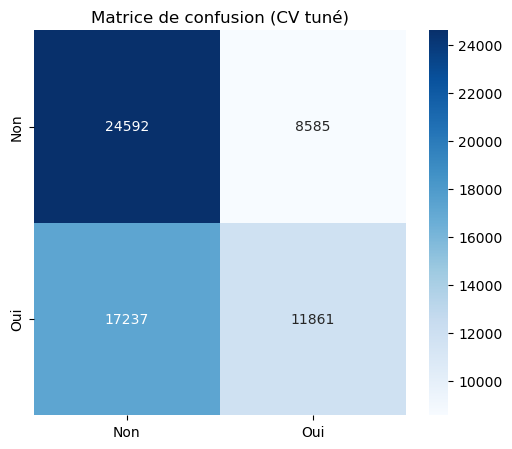

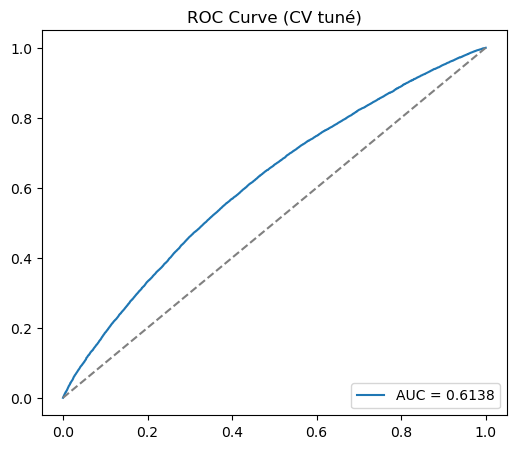

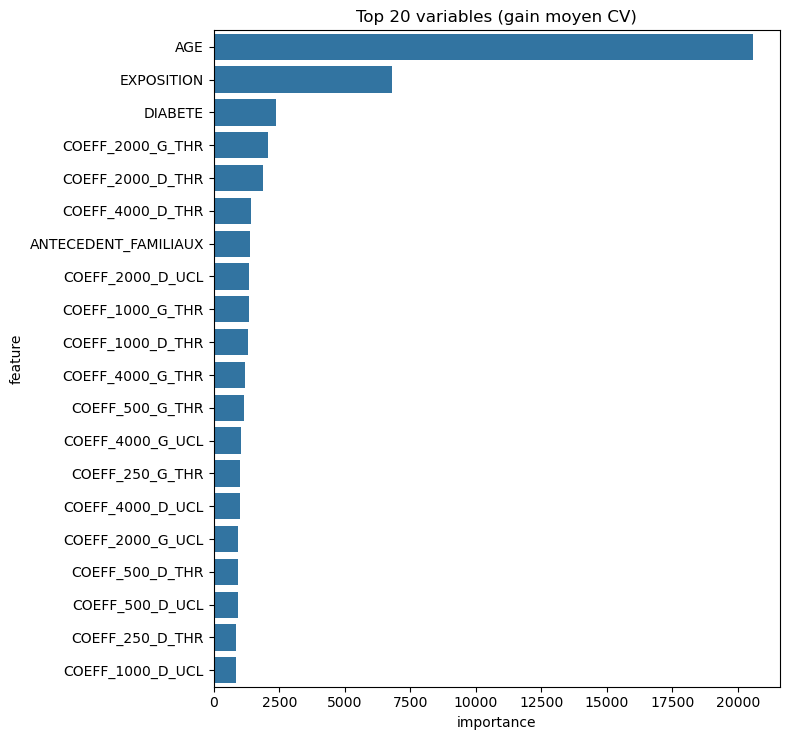

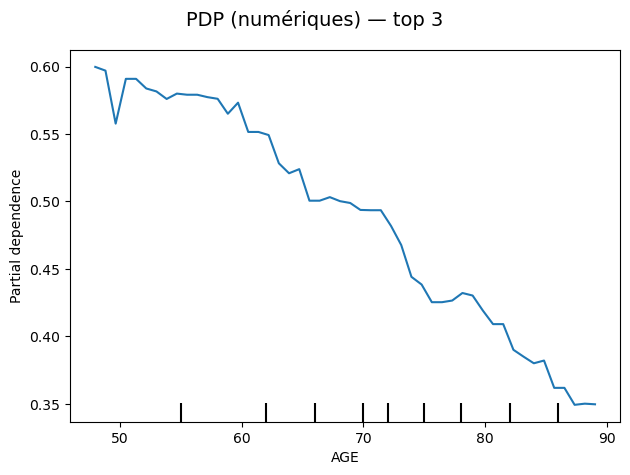

=== CV 5 plis — hyperparams tunés ===
Accuracy : 0.583203532717784
Precision: 0.5821309075700544
Recall   : 0.3826723486150251
F1-score : 0.46178409986314434

Classification Report:
               precision    recall  f1-score   support

           0     0.5837    0.7591    0.6599     33177
           1     0.5821    0.3827    0.4618     29098

    accuracy                         0.5832     62275
   macro avg     0.5829    0.5709    0.5609     62275
weighted avg     0.5830    0.5832    0.5673     62275



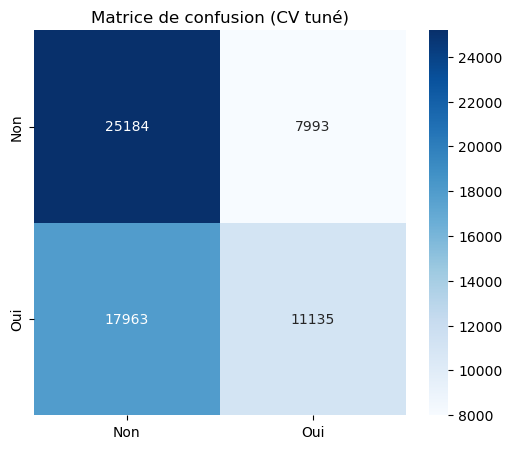

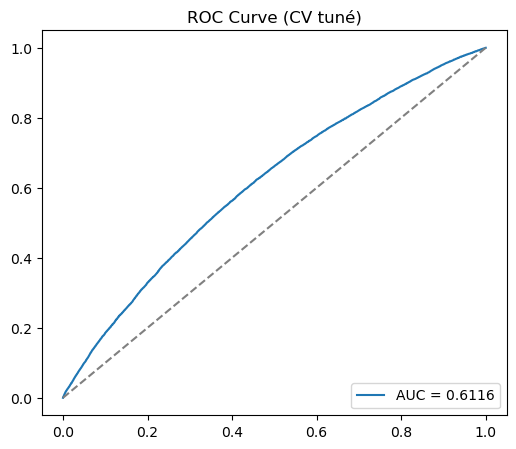

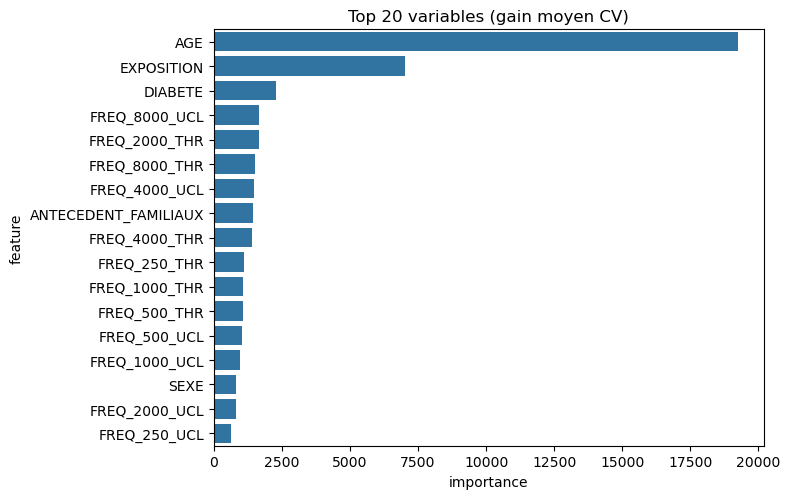

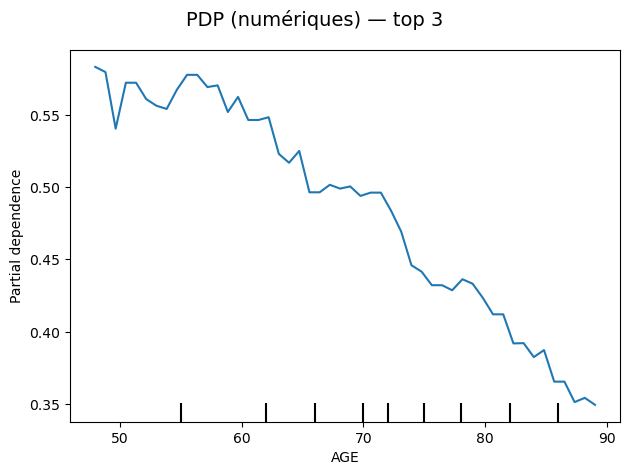

In [27]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)

import pandas as pd
pd.options.mode.chained_assignment = None

for df in list_of_dfs:
    train_lightgbm(df, top_k=3)